Данный ноутбук является второй эпостасией попыток найти решение.

Дабы не корректировать первый, зафиксировать те результаты, которых я достиг и возвращаться к ним при необходимости.

Здесь для начала хочу получше разобраться с данными и фичами.

Затем все таки нормализовать уменьшить размерность данных, нормализовать их, обучить алгоритмы LogReg, SVM, Decision Tree, CatBoost и произвести стэкинг и попытьася улучшить скор.

### Импорты

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders.cat_boost import CatBoostEncoder

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import time
import warnings
from tqdm import tqdm

from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

import os
os.environ["JOBLIB_TEMP_FOLDER"] = "/tmp"

### Загрузка данных

In [89]:
start = time.time()
train = pd.read_csv('./data/train.csv')
elapsed = time.time() - start
print(f'Time is: {elapsed} seconds')

Time is: 21.30223035812378 seconds


In [90]:
start = time.time()
test = pd.read_csv('./data/test.csv')
elapsed = time.time() - start
print(f'Time is: {elapsed} seconds')

Time is: 6.1183061599731445 seconds


In [57]:
start = time.time()
train = pd.read_csv('./data/balanced_train.csv')
elapsed = time.time() - start
print(f'Time is: {elapsed} seconds')

Time is: 4.453861713409424 seconds


In [54]:
start = time.time()
test = pd.read_csv('./data/balanced_test.csv')
elapsed = time.time() - start
print(f'Time is: {elapsed} seconds')

Time is: 2.3832428455352783 seconds


### Оптимизация

In [91]:
def optimize_data(df):
    # оптимизируем числовые данные
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    # Оптимизируем даты
    df["created_at"] = pd.to_datetime(df["created_at"])
    df["start_dt"] = pd.to_datetime(df["start_dt"])

    return df

In [92]:
# Размер трейна до оптимизации
print(f"Размер датасета до оптимизации: {train.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
train = optimize_data(train)
# Размер трейна после оптимизации
print(f"Размер датасета после оптимизации: {train.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Размер датасета до оптимизации: 3231.96 MB
Размер датасета после оптимизации: 2150.51 MB


In [93]:
# Размер теста до оптимизации
print(f"Размер датасета до оптимизации: {test.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
test = optimize_data(test)
# Размер теста после оптимизации
print(f"Размер датасета после оптимизации: {test.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Размер датасета до оптимизации: 971.89 MB
Размер датасета после оптимизации: 619.54 MB


### EDA

In [94]:
# will drop the closed_at, because it isn't in test
train.drop(['closed_at'], inplace=True, axis=1)

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 44 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   monthly_income         float32       
 1   work_experience        float32       
 2   requested_sum          float32       
 3   main_agreement_amount  float32       
 4   main_agreement_term    float32       
 5   requested_period_days  float32       
 6   requested_amount       float32       
 7   req_app_amount         float32       
 8   approved_amount        float32       
 9   period_days            float32       
 10  days_finish_loan       float32       
 11  ag                     float32       
 12  cnt_ext                float32       
 13  term                   float32       
 14  price                  float32       
 15  elecs_sum              float32       
 16  recurents_sum          float32       
 17  tamount                float32       
 18  issues                

Я не разбирался с пропусками детально, а просто дропал столбики, где пропусков было прям много.

Такие значения можно не дропать, а заменить на 0 / 'unknown'

Взглянем на столбики, в которых пропущены значения

In [24]:
train.isnull().sum()

monthly_income               207
work_experience          2648360
requested_sum            3546390
main_agreement_amount          0
main_agreement_term            0
requested_period_days     441618
requested_amount          414836
req_app_amount            414836
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  3582556
term                     3582556
price                    3582816
elecs_sum                   5794
recurents_sum               5794
tamount                     1774
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 84476
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface 

Есть небольшие пропуски в некоторых столбцах, а в некоторых прям ПРИЛИЧНЫЕ.

Отличились следующие фичи:
- work_experience - стаж - 65% пропусков
- requested_sum - запрашиваемая сумма клиента для займа - 88% пропусков
- cnt_ext - кол-во пролонгаций по займу - 89% пропусков
- term - срок пролонгации (список) - 89% пропусков
- price -  цена пролонгации (список) - 89% пропусков
- start_dt  -  дата начала (список) пролонгаций по займу - 89% пропусков
- contact_cases - кол-во обращений клиента с коллекшн - 94% пропусков

Надо их разобрать.

In [96]:
some_null = ['monthly_income', 'elecs_sum', 'recurents_sum', 'tamount', 'nbki_score','requested_period_days', 'requested_amount', 'req_app_amount']
many_null = ['work_experience','requested_sum','cnt_ext','term','price','contact_cases','start_dt']

In [97]:
train[some_null]

,monthly_income,elecs_sum,recurents_sum,tamount,nbki_score,requested_period_days,requested_amount,req_app_amount
0,-0.000735,-0.063933,-0.143015,-0.434972,1.837623,-0.389028,-1.053530,-0.629296
1,-0.000742,-0.063933,-0.143015,-0.434972,2.262600,-1.294731,-0.436189,-0.020140
2,-0.000742,-0.063933,-0.143015,-0.429509,2.262600,-1.113590,-0.259806,0.153905
3,-0.000742,-0.063933,-0.143015,-0.413118,2.262600,-1.385301,1.239449,1.633284
4,-0.000742,-0.063933,-0.143015,-0.320236,2.262600,-1.657011,0.357534,0.763061
...,...,...,...,...,...,...,...,...
4036202,-0.000747,-0.063933,-0.143015,-0.252851,0.866246,NaN,NaN,NaN
4036203,-0.000747,-0.063933,-0.143015,-0.708154,-1.180584,0.426103,-1.141721,-1.064407
4036204,-0.000739,-0.063933,-0.143015,0.202452,-0.100794,NaN,NaN,NaN
4036205,-0.000730,-0.063933,-0.143015,0.111392,0.367548,0.426103,-0.083423,-0.194184


Данные, где небольшое кол-во пропусков заполню средними значениями по данными фичам.

In [27]:
train[many_null]

,work_experience,requested_sum,cnt_ext,term,price,contact_cases,start_dt
0,0.952894,NaN,NaN,NaN,NaN,NaN,NaT
1,0.952894,NaN,NaN,NaN,NaN,NaN,NaT
2,0.952894,NaN,NaN,NaN,NaN,NaN,NaT
3,0.952894,NaN,NaN,NaN,NaN,NaN,2024-01-12 17:29:21
4,0.952894,NaN,1.407752,-0.612324,-0.705103,NaN,NaT
...,...,...,...,...,...,...,...
4036202,NaN,-0.592014,NaN,NaN,NaN,NaN,NaT
4036203,0.084114,NaN,NaN,NaN,NaN,NaN,NaT
4036204,NaN,-0.592014,NaN,NaN,NaN,NaN,NaT
4036205,0.084114,NaN,NaN,NaN,NaN,NaN,NaT


In [28]:
train['contact_cases'].max()

64.0


`Пролонгация займа - это возможность продлить срок возврата взятого кредита без необходимости полного его погашения.`

То есть, увеличение срока кредита, по тем или иным обстоятельствам.

Соответственно, я думаю, что фичи:
- cnt_ext - кол-во пролонгаций по займу - 89% пропусков
- term - срок пролонгации (список) - 89% пропусков
- price -  цена пролонгации (список) - 89% пропусков
- start_dt  -  дата начала (список) пролонгаций по займу - 89% пропусков

По сути будут сильнокоррелировать.

Необходимо пропуски заполнить 0, оставив только cnt_ext

- пропущенные в 'contact_cases' так же заполняем нулями.

- пропуски в 'work_experience' так же заполню нулями

#### Обработка пропусков

In [98]:
droplist = ['term','price','start_dt','client_type.1']
zeroslist = ['cnt_ext','contact_cases', 'work_experience', 'requested_sum'] + some_null

In [99]:
train.drop(axis=1, labels=droplist, inplace=True)
test.drop(axis=1, labels=droplist, inplace=True)

In [100]:
# заполняем нулями все подряд
train[zeroslist] = train[zeroslist].fillna(0)
test[zeroslist] = test[zeroslist].fillna(0)

In [101]:
train.isnull().sum()

monthly_income           0
work_experience          0
requested_sum            0
main_agreement_amount    0
main_agreement_term      0
requested_period_days    0
requested_amount         0
req_app_amount           0
approved_amount          0
period_days              0
days_finish_loan         0
ag                       0
cnt_ext                  0
elecs_sum                0
recurents_sum            0
tamount                  0
issues                   0
principal                0
interest                 0
overdue_interest         0
overdue_fee              0
nbki_score               0
payment_frequency        0
status                   0
loan_id                  0
client_id                0
source                   0
first_source             0
interface                0
type                     0
repayment_type           0
client_type              0
settlement               0
region                   0
gender                   0
loan_order               0
have_extension           0
c

### Обработка категориальных фичей

#### Бинарные признаки

In [102]:
# удаляем регион
# для трейна
train.drop(columns=['region'], inplace=True)
# для теста
test.drop(columns=['region'], inplace=True)

In [103]:
# кодируем бинарные признаки для трейна
label_enc_cols = ['gender']
for col in label_enc_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

In [104]:
# кодируем бинарные признаки для теста
label_enc_cols = ['gender']
for col in label_enc_cols:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])

#### CatBoost Encoding

Города сильно различаются, поэтому **One-Hot Encoding не подойдёт** (слишком много новых фич).

CatBoost Encoding (учитывает вероятности, полезно для ML-моделей).

In [105]:
cat_enc = CatBoostEncoder()
train['settlement'] = cat_enc.fit_transform(train['settlement'], train['churn'])

In [106]:
# Применяем обученный энкодер к test (без .fit!)
test['settlement'] = cat_enc.transform(test['settlement'])

#### дата
Даты нельзя просто так закодировать.

От них нужно или отказаться или же выделить полезные числовые признаки.

Получим новые признаки, а исходные столбцы удалим

In [107]:
# для трейна
train['created_at'] = pd.to_datetime(train['created_at'])

# День, месяц, год, день недели
train['created_day'] = train['created_at'].dt.day
train['created_month'] = train['created_at'].dt.month
train['created_weekday'] = train['created_at'].dt.weekday  # 0 = Понедельник, 6 = Воскресенье

# Удаление изначальных столбцов
train.drop(columns=['created_at'], inplace=True)

In [108]:
# для теста
test['created_at'] = pd.to_datetime(test['created_at'])

# День, месяц, год, день недели
test['created_day'] = test['created_at'].dt.day
test['created_month'] = test['created_at'].dt.month
test['created_weekday'] = test['created_at'].dt.weekday  # 0 = Понедельник, 6 = Воскресенье

# Удаление изначальных столбцов
test.drop(columns=['created_at'], inplace=True)

In [109]:
# взглянем на обновленные категориальные фичи!
cat_cols = ['settlement','gender', 'created_day','created_month','created_weekday']
train[cat_cols]

,settlement,gender,created_day,created_month,created_weekday
0,0.293872,1,23,12,4
1,0.146936,0,29,6,5
2,0.293872,1,10,4,0
3,0.293872,0,1,10,6
4,0.097957,0,15,7,0
...,...,...,...,...,...
4036202,0.256162,0,3,5,2
4036203,0.263662,0,13,9,2
4036204,0.287153,1,13,12,2
4036205,0.275080,1,27,8,1


### Баланс классов

In [112]:
train['churn'].value_counts()

churn
0    2850077
1    1186130
Name: count, dtype: int64

In [113]:
# Разделяем классы
churn_0 = train[train['churn'] == 0]
churn_1 = train[train['churn'] == 1]

In [114]:
# **Undersampling:** случайно удаляем 831973 записей класса 0
churn_0_sampled = churn_0.sample(n=len(churn_0) - 831973, random_state=42)
# **Undersampling:** случайно удаляем 1663947 записей класса 0
#churn_0_sampled = churn_0.sample(n=len(churn_0) - 1663947, random_state=42)

In [115]:
# Объединяем обе выборки перед SMOTE
train_balancing = pd.concat([churn_0_sampled, churn_1], axis=0)

In [116]:
# **Oversampling:** добавляем 831974 записей класса 1 с помощью SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy=1.0, random_state=42).fit_resample(
    train_balancing.drop(columns=['churn']), train_balancing['churn'])

In [117]:
# Превращаем в датафрейм
balanced_train = pd.DataFrame(X_resampled, columns=train_balancing.drop(columns=['churn']).columns)
balanced_train['churn'] = y_resampled
train=balanced_train

In [118]:
# Проверяем баланс
print(train['churn'].value_counts())

churn
0    2018104
1    2018104
Name: count, dtype: int64


### Коррелирующие признаки

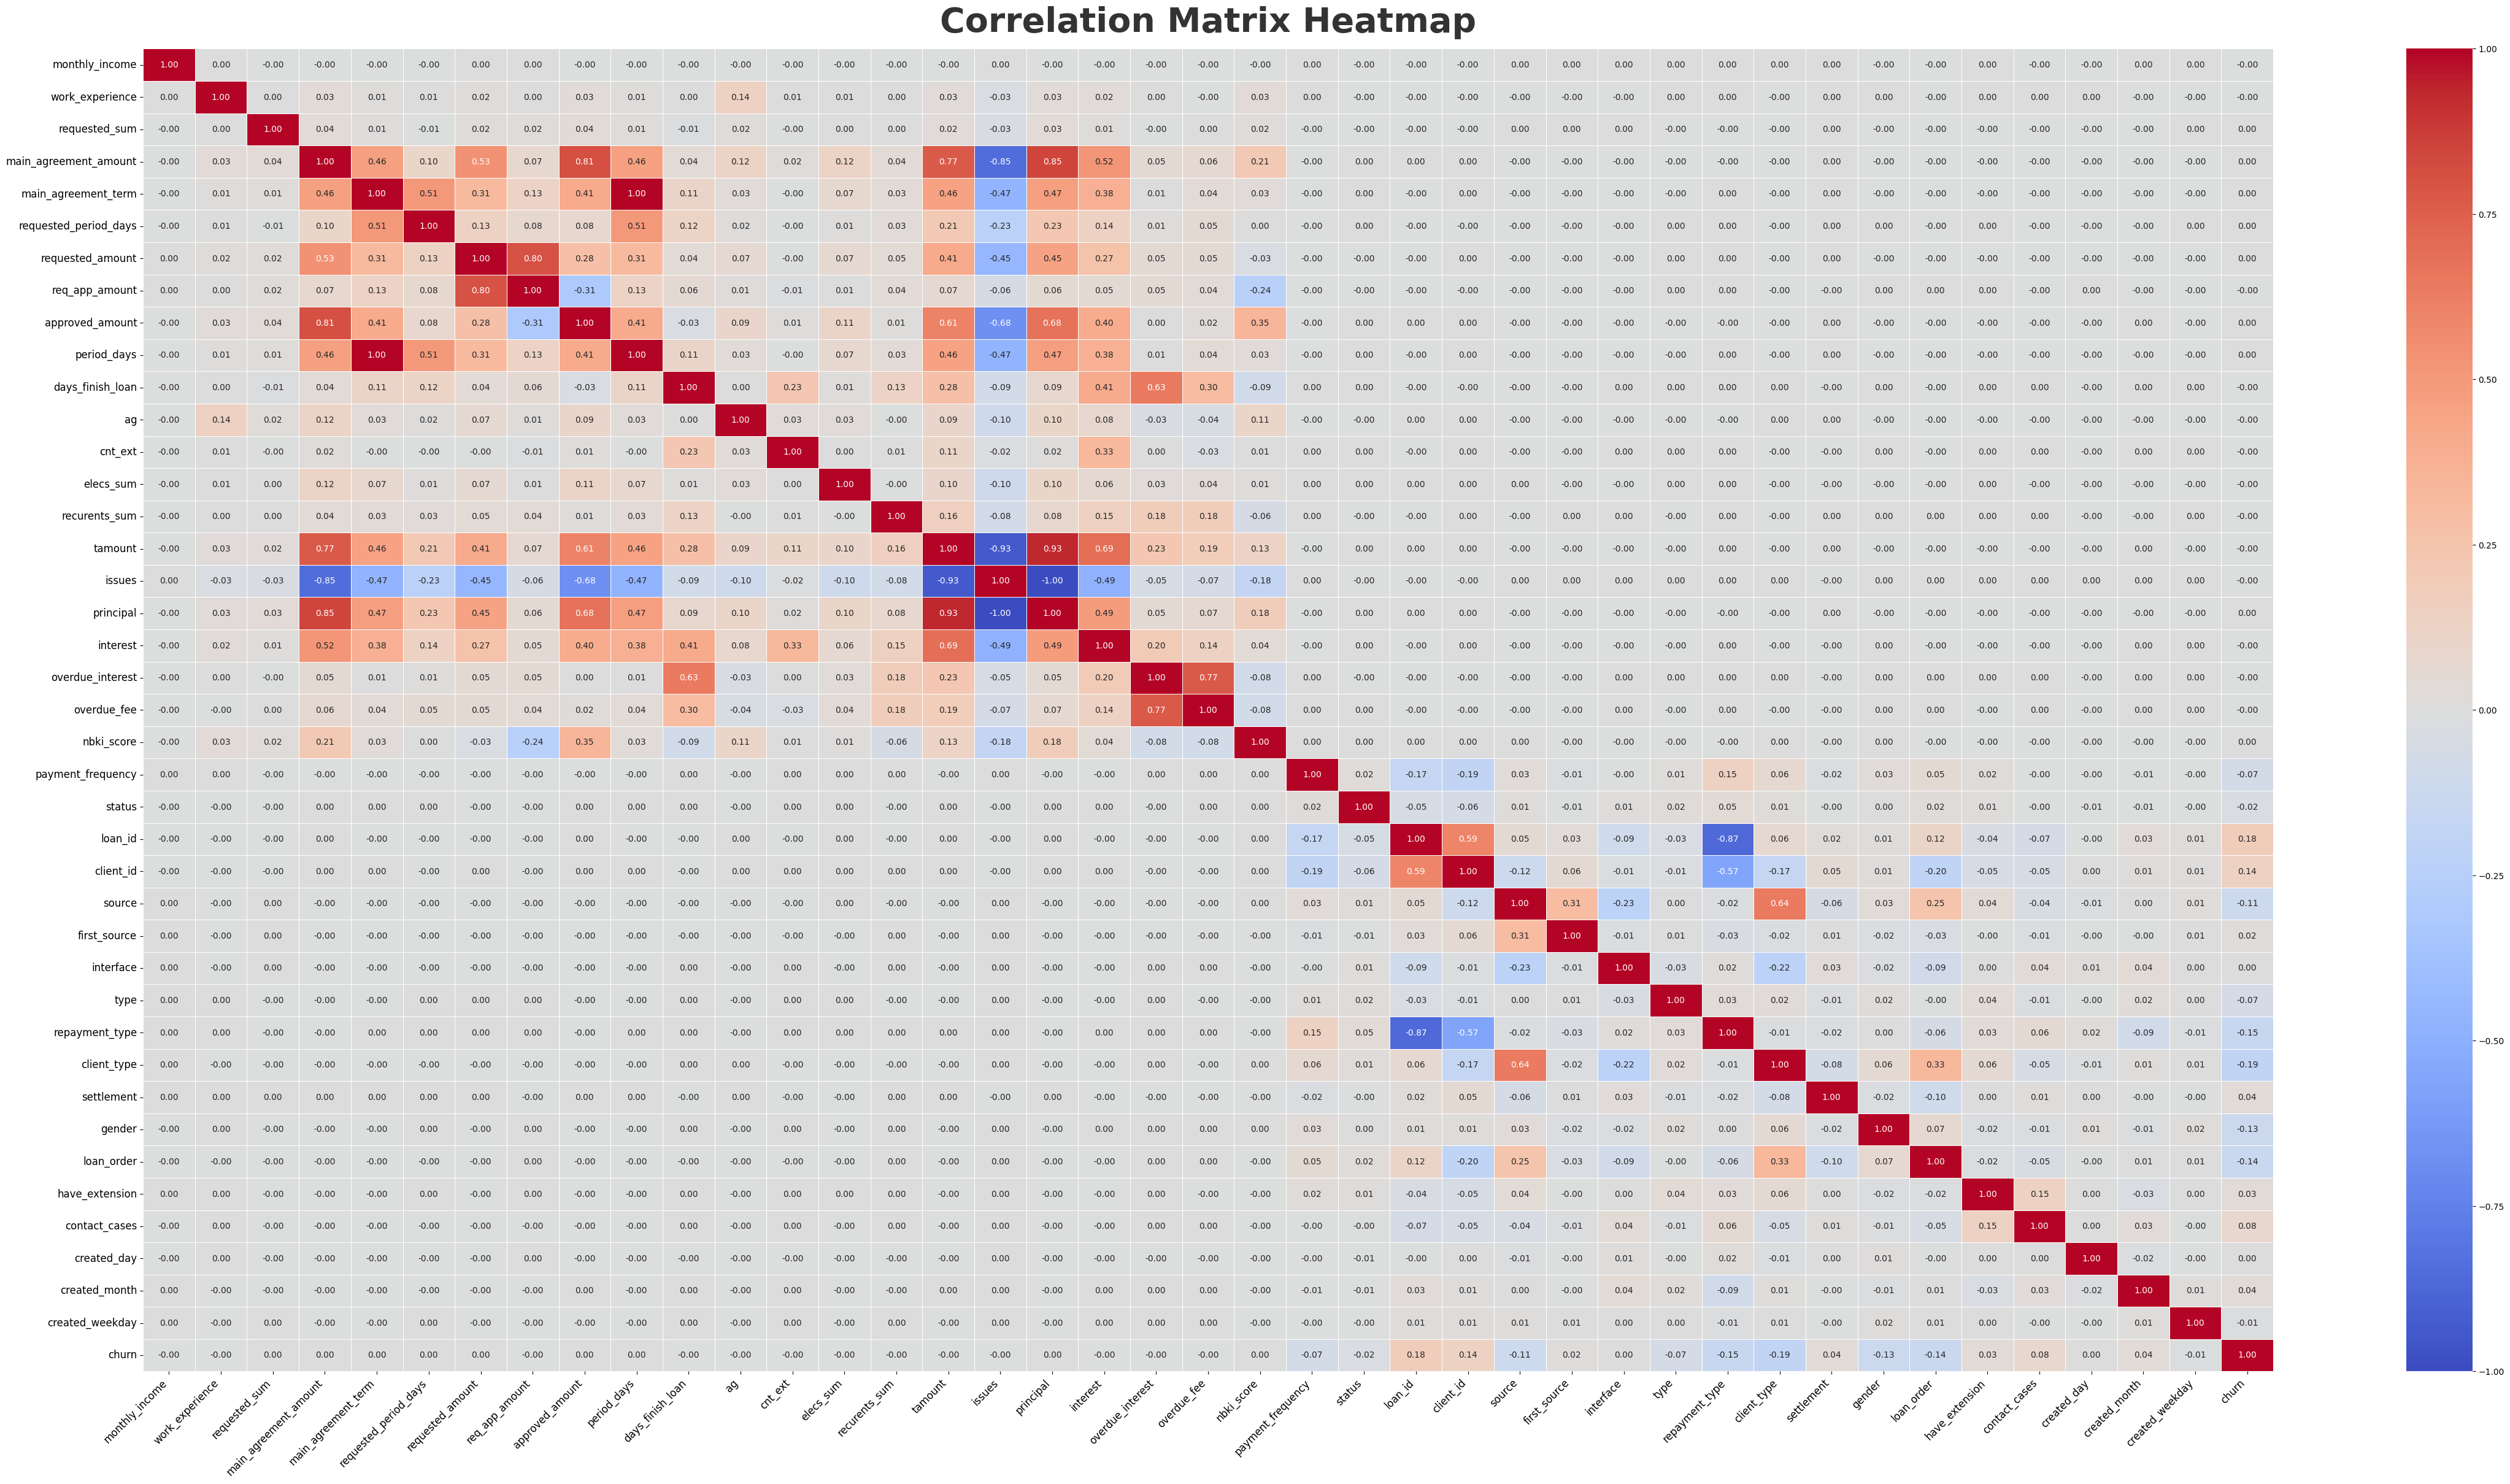

In [23]:
# создаем матрицу корреляций
correlation_matrix = train.corr()
# Создаём heatmap
plt.figure(figsize=(56, 28))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor="white"
)

# Настройки осей
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

# Заголовок
plt.title("Correlation Matrix Heatmap", fontsize=40, weight='bold', color="#333333", pad=20)

# **Сохраняем картинку**
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")  # 300 DPI для качества

# Показываем график
plt.show()

In [119]:
droplist = ['principal','tamount','main_agreement_term']

In [120]:
train.drop(labels=droplist, axis=1, inplace=True)

In [121]:
test.drop(labels=droplist, axis=1, inplace=True)

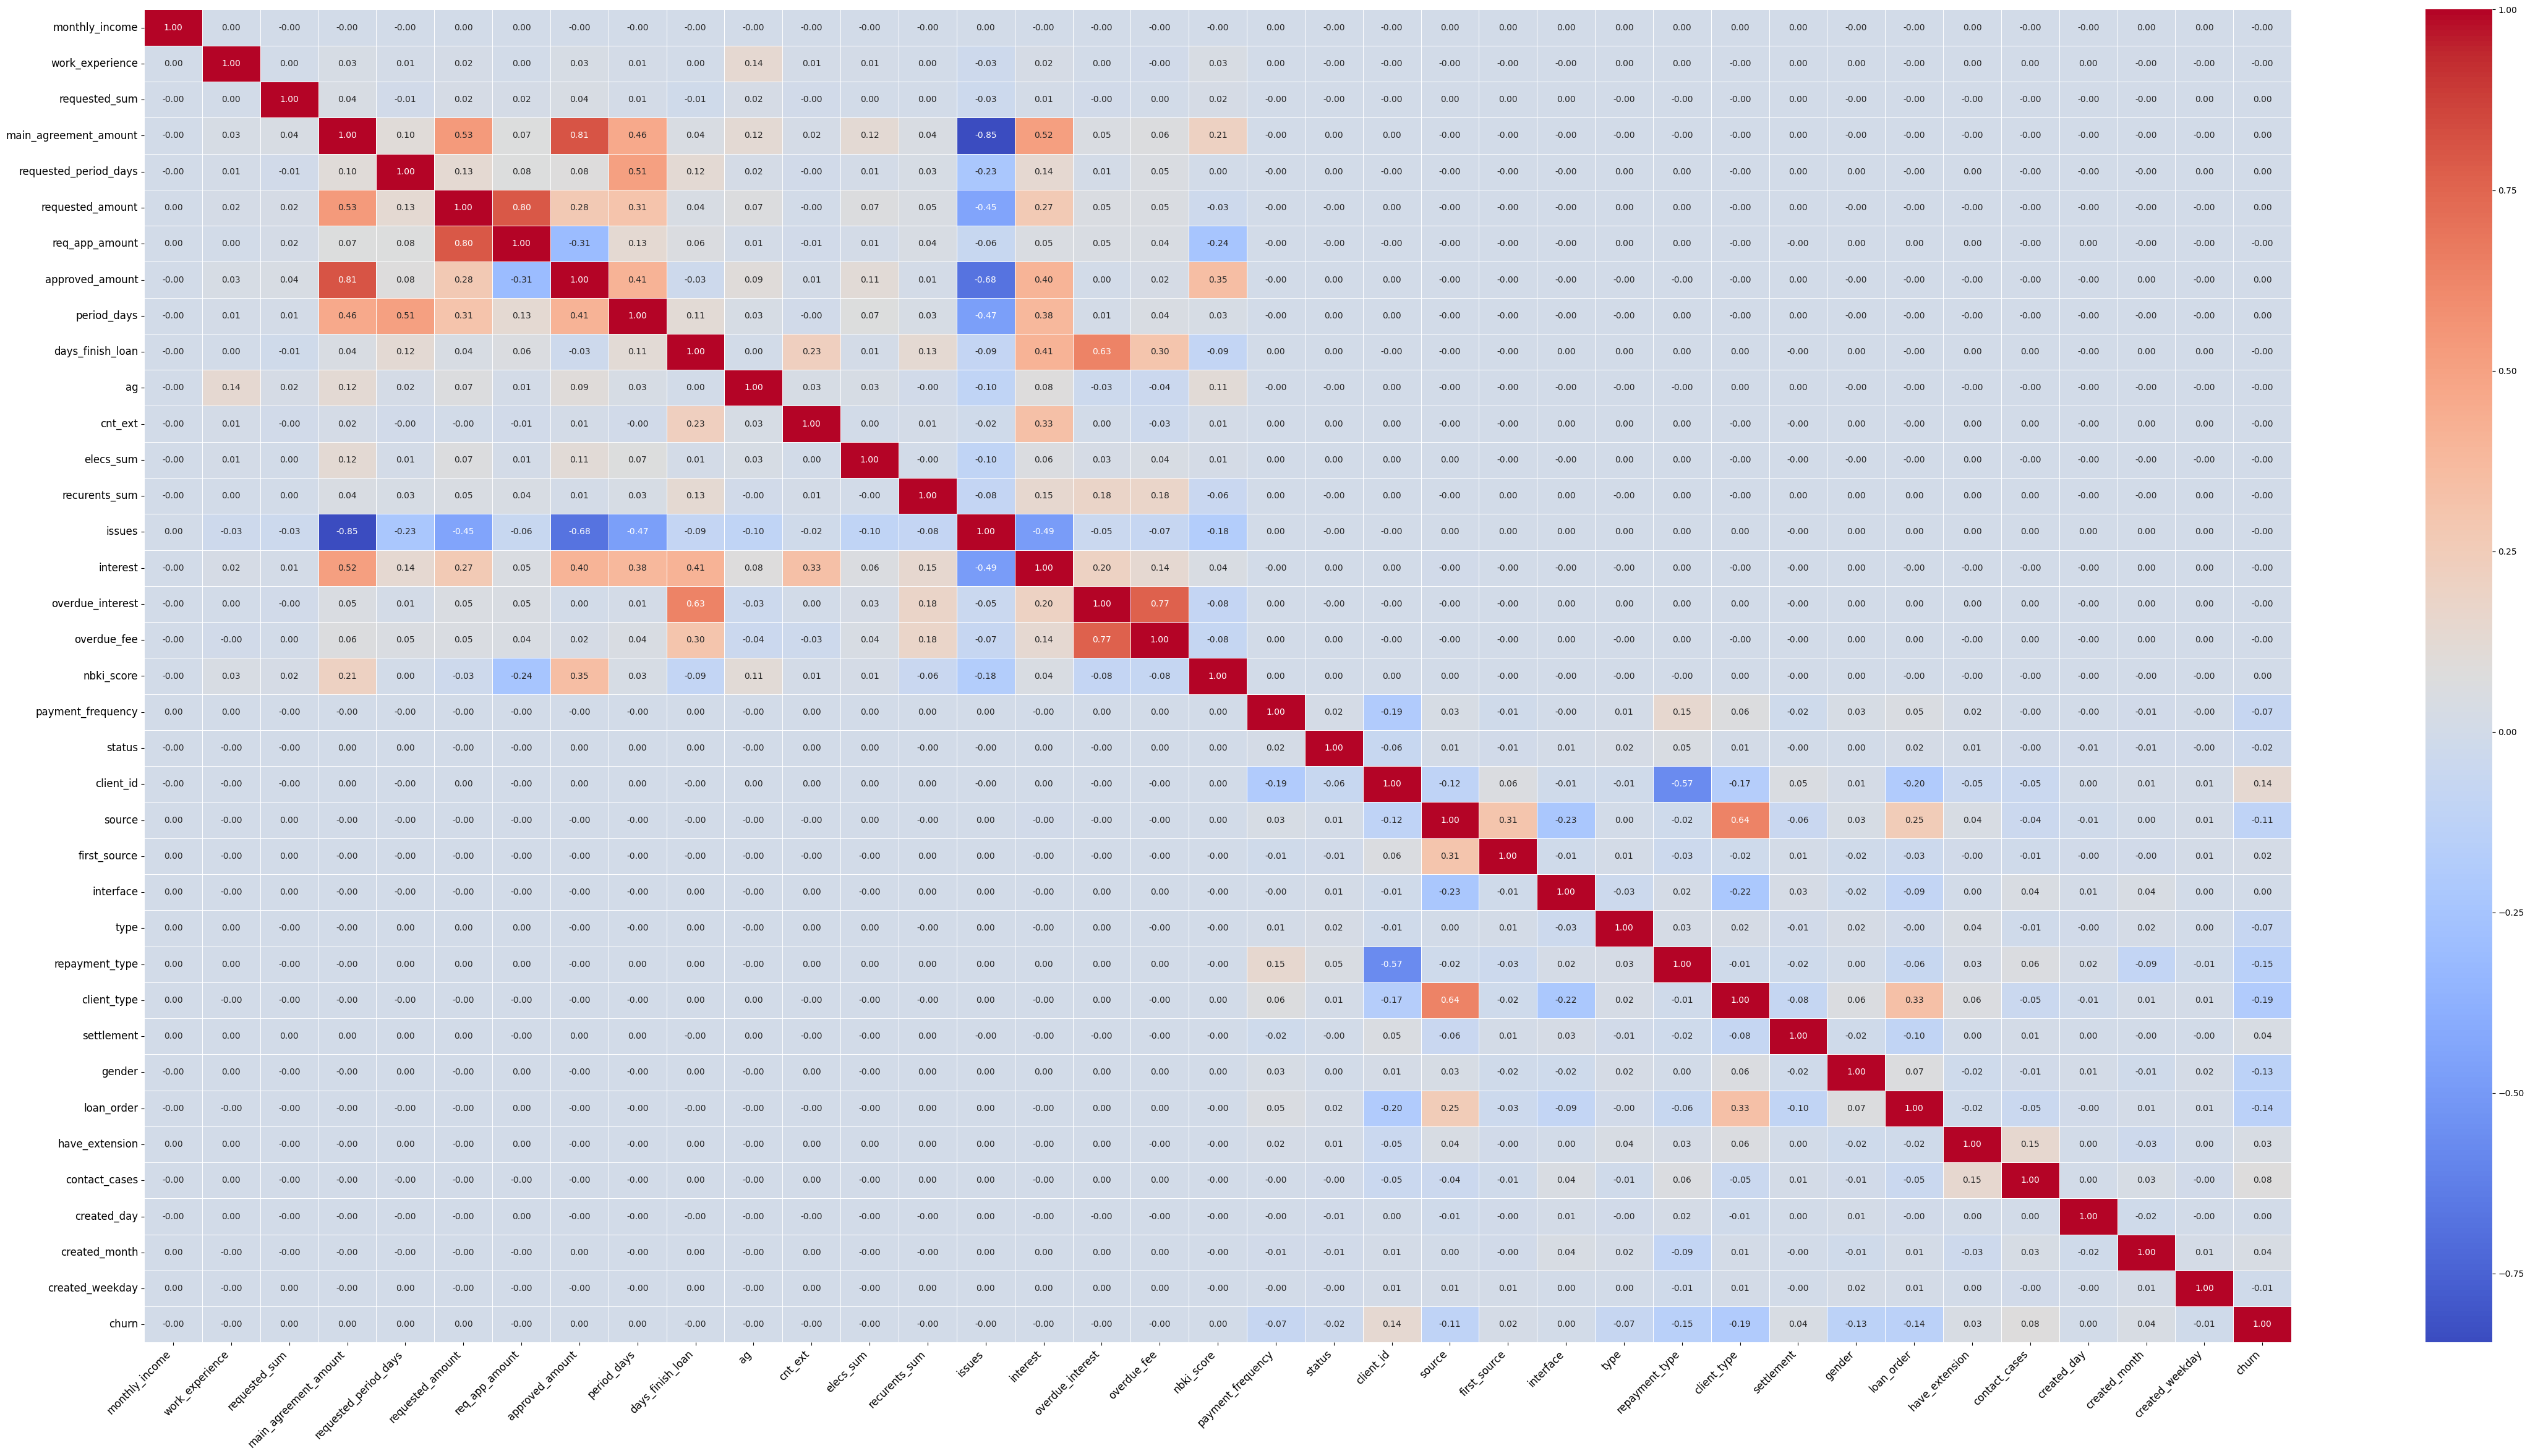

In [28]:
# создаем матрицу корреляций
correlation_matrix = train.corr()
# Создаём heatmap
plt.figure(figsize=(56, 28))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor="white"
)

# Настройки осей
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

# Показываем график
plt.show()

In [122]:
train.to_csv("balanced_train.csv", index=False)

In [123]:
test.to_csv("balanced_test.csv", index=False)

### Нормализация данных

In [95]:
#scaler = StandardScaler()

In [89]:
#train_std = scaler.fit_transform(train)
#test_std = scaler.fit_transform(test)

### Уменьшение размерности

### Обучение моделей

Я планирую сделать стэкинг из нескольких моделей. Предварительно обучив их и подобрав для них лучшие параметры с помощью GridSearchCV.

Модели для обучения:
- LogisticRegression
- SVC
- RandomForest
- CatBoost

#### Разделение данных

In [ ]:
# # Преобразование числовых данных
# numeric_transformer = Pipeline(steps=[
#     ("scaler", StandardScaler())
# ])

# preprocessor = ColumnTransformer(
#     transformers=[("num", numeric_transformer, X_train.columns)]
# )

# # Гиперпараметры для kNN
# PARAMS = {
#     "model__n_neighbors": range(3, 31, 4),
#     "model__metric": ["cityblock", "euclidean", "manhattan"]
# }

# # Модель
# clf = Pipeline(steps=[
#     ("preproc", preprocessor),
#     ("model", KNeighborsClassifier(n_jobs=-1, weights="distance"))
# ])

# # Подсчет количества комбинаций гиперпараметров
# total_combinations = np.prod([len(v) for v in PARAMS.values()])
# total_iterations = total_combinations * 5  # cv=5

# # Убираем `callback`, который вызывал ошибку PicklingError
# start_time = time.time()

# # Поиск гиперпараметров
# grid_search = GridSearchCV(
#     estimator=clf,
#     param_grid=PARAMS,
#     scoring="roc_auc",
#     n_jobs=1,  # Отключаем параллельное выполнение (фикс PicklingError)
#     cv=5,
#     refit=True,
#     verbose=3  # Теперь видно прогресс без `tqdm`
# )

# knn = grid_search.fit(X_train, y_train)  # callback удален!

# # Итоговое время выполнения
# end_time = time.time()
# minutes, seconds = divmod(end_time - start_time, 60)

# print(f"✅ Подбор завершён! Время: {int(minutes)} мин {int(seconds)} сек")
# print(f"🔹 Лучшие параметры: {knn.best_params_}")

# # Оценка на тесте
# y_pred_proba = knn.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# print(f"🎯 ROC AUC на тесте: {roc_auc:.4f}")

Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [124]:
# Разделение данных
X = train.drop(columns=["churn"])
y = train["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Logistic Regression

In [15]:
# Pipeline с нормализацией
pipeline = Pipeline([
    ("scaler", StandardScaler()),         # Нормализация данных
    ("pca", PCA(n_components=0.95)),      # Уменьшение размерности до 95% дисперсии
    ("model", LogisticRegression(max_iter=500, random_state=42, class_weight='balanced'))
])

# Гиперпараметры для перебора
param_grid = {
    "model__C": np.logspace(-4, 4, 10),  # Регуляризация
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear", "saga"]  # Поддержка l1/l2
}

# GridSearch с ограничением потоков
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=4,  # Уменьшаем число потоков
    cv=5,
    verbose=1
)

# Засекаем время выполнения
start_time = time.time()

# Запуск GridSearch
logreg = grid_search.fit(X_train, y_train)

# Время выполнения
end_time = time.time()
execution_time = end_time - start_time

# Вывод времени выполнения
print(f"Total time for GridSearch: {execution_time:.2f} seconds")

# Лучшие параметры
print(f"Лучшие параметры: {logreg.best_params_}")

# Предсказания
y_pred = logreg.predict(X_test)

# Метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Вывод метрик
print("\nModel Performance on Test Data:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Оценка ROC AUC
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC на тесте: {roc_auc:.4f}")

# Сохранение лучших гиперпараметров
best_params = logreg.best_params_
pd.DataFrame([best_params]).to_csv("best_params_logreg.csv", index=False)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Total time for GridSearch: 2151.02 seconds
Лучшие параметры: {'model__C': 10000.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Model Performance on Test Data:
Accuracy:  0.6292
Precision: 0.6295
Recall:    0.6292
F1 Score:  0.6290

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64    403621
           1       0.64      0.61      0.62    403621

    accuracy                           0.63    807242
   macro avg       0.63      0.63      0.63    807242
weighted avg       0.63      0.63      0.63    807242

ROC AUC на тесте: 0.6792


#### SVC

потом до меня дошло. что я не использовал уменьшение размерности, и что по идее должно было быстрее перебирать параметры. вот я нубло то а)

In [ ]:
# # Создаем Pipeline с нормализацией и PCA
# pipeline = Pipeline([
#     ("scaler", StandardScaler()),  
#     ("pca", PCA()),  
#     ("model", SVC(probability=True, random_state=42, class_weight="balanced"))  
# ])

# # Гиперпараметры для RandomizedSearchCV
# param_dist = {
#     "pca__n_components": np.linspace(0.9, 0.99, 3),  # Уменьшаем до 3 вариантов
#     "model__C": np.logspace(-3, 3, 7),  # Меньше значений C
#     "model__kernel": ["linear", "rbf"],  # Убраны медленные "poly" и "sigmoid"
#     "model__gamma": ["scale", "auto"]
# }

# # RandomizedSearchCV с 200 случайными комбинациями
# random_search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_dist,
#     n_iter=200,  
#     scoring="roc_auc",
#     n_jobs=8,  
#     cv=3,  
#     verbose=1,
#     random_state=42
# )

# # Засекаем время
# start_time = time.time()

# # Запуск RandomizedSearchCV
# svc = random_search.fit(X_train, y_train)

# # Время выполнения
# execution_time = time.time() - start_time
# print(f"Total time for RandomizedSearch: {execution_time:.2f} seconds")

# # Лучшие параметры
# print(f"Лучшие параметры: {svc.best_params_}")

# # Сохранение параметров
# pd.DataFrame([svc.best_params_]).to_csv("best_params_svc.csv", index=False)

In [ ]:
# Pipeline для SVC
svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("pca", PCA(n_components=0.95)),  
    ("model", SVC(probability=True, random_state=42, class_weight="balanced"))
])

# Гиперпараметры
svc_param_dist = {
    "model__C": np.logspace(-2, 2, 5),
    "model__kernel": ["linear", "rbf"],  
    "model__gamma": ["scale", "auto"]
}

# HalvingRandomSearchCV с исправленными параметрами
svc_search = HalvingRandomSearchCV(
    estimator=svc_pipeline,
    param_distributions=svc_param_dist,
    factor=2,  
    min_resources="smallest",  # Исправлено
    scoring="roc_auc",
    n_jobs=8,  
    cv=3,  
    verbose=1,
    random_state=42
)

# Засекаем время
start_time = time.time()
svc = svc_search.fit(X_train, y_train)
execution_time = time.time() - start_time

print(f"SVC Search Time: {execution_time:.2f} sec")
print(f"Best SVC Params: {svc.best_params_}")
pd.DataFrame([svc.best_params_]).to_csv("best_params_svc.csv", index=False)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 19
min_resources_: 12
max_resources_: 3228966
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 20
n_resources: 12
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 10
n_resources: 24
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 5
n_resources: 48
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 3
n_resources: 96
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 4
n_candidates: 2
n_resources: 192
Fitting 3 folds for each of 2 candidates, totalling 6 fits


#### RandomForest

In [ ]:
# # Создаем Pipeline с нормализацией и PCA
# pipeline = Pipeline([
#     ("scaler", StandardScaler()), 
#     ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
# ])

# # Гиперпараметры для RandomizedSearchCV
# param_dist = {
#     "pca__n_components": np.linspace(0.9, 0.99, 3),  # Три варианта PCA
#     "model__n_estimators": [50, 100, 200],  
#     "model__max_depth": [None, 10, 20],  
#     "model__min_samples_split": [2, 5],  
#     "model__min_samples_leaf": [1, 2],  
#     "model__bootstrap": [True, False]  
# }

# # RandomizedSearchCV с 200 случайными комбинациями
# random_search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_dist,
#     n_iter=200,  # Вместо 7200 комбинаций → 200
#     scoring="roc_auc",
#     n_jobs=8,  # Используем все ядра
#     cv=3,  # Вместо 5-fold используем 3-fold
#     verbose=1,
#     random_state=42
# )

# # Засекаем время
# start_time = time.time()

# # Запуск RandomizedSearchCV
# rf = random_search.fit(X_train, y_train)

# # Время выполнения
# execution_time = time.time() - start_time
# print(f"Total time for RandomizedSearch: {execution_time:.2f} seconds")

# # Лучшие параметры
# print(f"Лучшие параметры: {rf.best_params_}")

# # Сохранение параметров
# pd.DataFrame([rf.best_params_]).to_csv("best_params_rf.csv", index=False)

In [ ]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

rf_param_dist = {
    "model__n_estimators": [50, 100, 200],  
    "model__max_depth": [None, 10, 20],  
    "model__min_samples_split": [2, 5],  
    "model__min_samples_leaf": [1, 2],  
    "model__bootstrap": [True, False]  
}

rf_search = HalvingRandomSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    factor=2,  # В 2 раза сокращаем неэффективные комбинации
    min_resources="exhaust",  # Используем минимум примеров в начале
    scoring="roc_auc",
    n_jobs=8,  
    cv=3,  
    verbose=1,
    random_state=42
)

start_time = time.time()
rf = rf_search.fit(X_train, y_train)
execution_time = time.time() - start_time

print(f"RF Search Time: {execution_time:.2f} sec")
print(f"Best RF Params: {rf.best_params_}")
pd.DataFrame([rf.best_params_]).to_csv("best_params_rf.csv", index=False)

#### CatBoost

⏳ Текущий подбор параметров займет ~2.5 - 3 часа.
⚡ С n_jobs=8 можно уложиться в ~1.5 часа.
🔥 Если сделать RandomizedSearch → 20-30 мин, а потом уточнять.

In [16]:
# # Подбор гиперпараметров для CatBoost
# param_grid = {
#     "iterations": [100, 500, 1000],
#     "learning_rate": [0.01, 0.1, 0.3],
#     "depth": [4, 6, 10],
#     "l2_leaf_reg": [1, 3, 5, 10],
#     "border_count": [32, 50, 100]
# }

# # Модель CatBoost без предварительной обработки данных
# catboost = CatBoostClassifier(verbose=0, random_state=42, auto_class_weights="Balanced")

# grid_search = GridSearchCV(
#     estimator=catboost,
#     param_grid=param_grid,
#     scoring="roc_auc",
#     n_jobs=4,
#     cv=5,
#     verbose=1
# )

# # Засекаем время выполнения
# start_time = time.time()

# # Запуск GridSearch
# cb = grid_search.fit(X_train, y_train)

# # Время выполнения
# end_time = time.time()
# execution_time = end_time - start_time

# # Вывод времени выполнения
# print(f"Total time for GridSearch: {execution_time:.2f} seconds")

# # Лучшие параметры
# print(f"Лучшие параметры: {cb.best_params_}")

# # Предсказания
# y_pred = cb.predict(X_test)

# # Метрики
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average="weighted")
# recall = recall_score(y_test, y_pred, average="weighted")
# f1 = f1_score(y_test, y_pred, average="weighted")

# # Вывод метрик
# print("\nModel Performance on Test Data:")
# print(f"Accuracy:  {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall:    {recall:.4f}")
# print(f"F1 Score:  {f1:.4f}")

# # Classification Report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Оценка ROC AUC
# y_pred_proba = cb.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# print(f"ROC AUC на тесте: {roc_auc:.4f}")

# # Сохранение лучших гиперпараметров
# best_params = cb.best_params_
# pd.DataFrame([best_params]).to_csv("best_params_cb.csv", index=False)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

In [17]:
param_grid = {
    "iterations": [100, 500],
    "learning_rate": [0.01, 0.1],
    "depth": [4, 6],
    "l2_leaf_reg": [1, 5],
    "border_count": [32, 50]
}

# CatBoost с ранней остановкой
catboost = CatBoostClassifier(
    verbose=0, 
    random_state=42, 
    auto_class_weights="Balanced", 
    early_stopping_rounds=20
)

# Случайный поиск вместо полного перебора
grid_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_grid,
    n_iter=20,  # Проверяем только 20 случайных комбинаций
    scoring="roc_auc",
    n_jobs=4,
    cv=5,
    verbose=1,
    random_state=42
)

# Засекаем время выполнения
start_time = time.time()

# Запуск поиска
cb = grid_search.fit(X_train, y_train)

# Время выполнения
execution_time = time.time() - start_time
print(f"Total time for GridSearch: {execution_time:.2f} seconds")

# Лучшие параметры
print(f"Лучшие параметры: {cb.best_params_}")

# Предсказания
y_pred = cb.predict(X_test)

# Метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print("\n📊 Model Performance on Test Data:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC
y_pred_proba = cb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC на тесте: {roc_auc:.4f}")

# Сохранение лучших параметров
pd.DataFrame([cb.best_params_]).to_csv("best_params_cb.csv", index=False)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

### Stacking

SVM оч сильно тупил, поэтому пришлось от него избавиться

In [ ]:
# # # === Загрузка лучших гиперпараметров ===
# # best_params_logreg = pd.read_csv('./data/best_params_logreg.csv').to_dict('records')[0]
# # best_params_svc = pd.read_csv('./data/best_params_svc.csv').to_dict('records')[0]
# # best_params_rf = pd.read_csv('./data/best_params_rf.csv').to_dict('records')[0]
# # best_params_cb = pd.read_csv('./data/best_params_cb.csv').to_dict('records')[0]

# # === Загрузка лучших гиперпараметров только для логистической регрессии и CatBoost ===
# best_params_logreg = pd.read_csv('./data/best_params_logreg.csv').to_dict('records')[0]

# # Убираем префикс "model__" из параметров логистической регрессии
# best_params_logreg = {k.replace("model__", ""): v for k, v in best_params_logreg.items()}

# # === Создание пайплайна для линейных моделей ===
# preprocessor = Pipeline([
#     ("scaler", StandardScaler()),   
#     ("pca", PCA(n_components=0.95))  # Уменьшение размерности до 95% дисперсии
# ])

# # Трансформация признаков для логрег и SVC
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)

# # === Инициализация моделей ===
# logreg = LogisticRegression(**best_params_logreg)  # Используем лучшие параметры
# svc = SVC(probability=True, random_state=42, class_weight="balanced")  # Дефолтные параметры + probability=True
# rf = RandomForestClassifier(random_state=42, class_weight="balanced")  # Дефолтные параметры
# catboost = CatBoostClassifier(logging_level='Silent', verbose=0, random_state=42, auto_class_weights="Balanced")

# # === Обучение базовых моделей ===
# logreg.fit(X_train_transformed, y_train)
# svc.fit(X_train_transformed, y_train)
# rf.fit(X_train, y_train)
# catboost.fit(X_train, y_train)

# # === Формируем новый датасет из предсказаний базовых моделей ===
# logreg_preds = logreg.predict_proba(X_test_transformed)[:, 1]
# svc_preds = svc.predict_proba(X_test_transformed)[:, 1]
# rf_preds = rf.predict_proba(X_test)[:, 1]
# catboost_preds = catboost.predict_proba(X_test)[:, 1]

# # Создаем новый набор признаков для метамодели
# X_meta_train = np.column_stack([logreg_preds, svc_preds, rf_preds, catboost_preds])

# # === Инициализация метамодели (CatBoost) ===
# meta = CatBoostClassifier(
#     logging_level='Silent',
#     eval_metric="AUC:hints=skip_train~false",
#     metric_period=1000,
#     random_seed=0,
#     grow_policy="Depthwise",
#     l2_leaf_reg=1,
#     learning_rate=0.08,
#     max_depth=10,
#     min_data_in_leaf=10,
#     n_estimators=10,
#     random_strength=11,
#     subsample=0.1,
# )

# # Обучение метамодели
# meta.fit(X_meta_train, y_test)

# # === Финальное предсказание ===
# y_pred = meta.predict(X_meta_train)

# # === Оценка качества модели ===
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average="weighted")
# recall = recall_score(y_test, y_pred, average="weighted")
# f1 = f1_score(y_test, y_pred, average="weighted")

# # Вывод метрик
# print("\n📊 Model Performance on Test Data:")
# print(f"Accuracy:  {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall:    {recall:.4f}")
# print(f"F1 Score:  {f1:.4f}")

# # Classification Report
# print("\n📋 Classification Report:")
# print(classification_report(y_test, y_pred))

# # === ROC AUC, если метамодель поддерживает predict_proba ===
# if hasattr(meta, "predict_proba"):
#     y_pred_proba = meta.predict_proba(X_meta_train)[:, 1]
#     roc_auc = roc_auc_score(y_test, y_pred_proba)
#     print(f"ROC AUC на тесте: {roc_auc:.4f}")


In [125]:
# === Загрузка лучших гиперпараметров только для логистической регрессии ===
best_params_logreg = pd.read_csv('./data/best_params_logreg.csv').to_dict('records')[0]
best_params_logreg = {k.replace("model__", ""): v for k, v in best_params_logreg.items()}  # Чистим префикс

# === Создание пайплайна для предобработки (только для LogReg) ===
preprocessor = Pipeline([
    ("scaler", StandardScaler()),   
    ("pca", PCA(n_components=0.95))  # Уменьшение размерности до 95% дисперсии
])

# Трансформация признаков для логрег
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# === Инициализация моделей ===
logreg = LogisticRegression(**best_params_logreg, n_jobs=8, class_weight='balanced')  # Логистическая регрессия с лучшими параметрами
rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced", n_jobs=8)  # Дефолтный RF
catboost = CatBoostClassifier(logging_level='Silent', random_state=42, auto_class_weights="Balanced")  # CatBoost с балансировкой

# === Обучение базовых моделей ===
print("🔹 Обучаем Logistic Regression...")
logreg.fit(X_train_transformed, y_train)

print("🔹 Обучаем Random Forest...")
rf.fit(X_train, y_train)

print("🔹 Обучаем CatBoost...")
catboost.fit(X_train, y_train)

# === Формируем новый датасет из предсказаний базовых моделей ===
print("🔹 Получаем предсказания для метамодели...")
logreg_preds = logreg.predict_proba(X_test_transformed)[:, 1]
rf_preds = rf.predict_proba(X_test)[:, 1]
catboost_preds = catboost.predict_proba(X_test)[:, 1]

# Создаем новый набор признаков для метамодели (без SVC)
X_meta_train = np.column_stack([logreg_preds, rf_preds, catboost_preds])

# === Инициализация метамодели (CatBoost) ===
meta = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1,
)

# Обучение метамодели
print("🔹 Обучаем метамодель (CatBoost)...")
meta.fit(X_meta_train, y_test)

# === Финальное предсказание ===
y_pred = meta.predict(X_meta_train)

# === Оценка качества модели ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Вывод метрик
print("\n📊 Model Performance on Test Data:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# === ROC AUC, если метамодель поддерживает predict_proba ===
if hasattr(meta, "predict_proba"):
    y_pred_proba = meta.predict_proba(X_meta_train)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC на тесте: {roc_auc:.4f}")

print("\n✅ Обучение завершено!")

🔹 Обучаем Logistic Regression...
🔹 Обучаем Random Forest...
🔹 Обучаем CatBoost...
🔹 Получаем предсказания для метамодели...
🔹 Обучаем метамодель (CatBoost)...

📊 Model Performance on Test Data:
Accuracy:  0.7520
Precision: 0.7773
Recall:    0.7520
F1 Score:  0.7463

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78    403621
           1       0.86      0.60      0.71    403621

    accuracy                           0.75    807242
   macro avg       0.78      0.75      0.75    807242
weighted avg       0.78      0.75      0.75    807242

ROC AUC на тесте: 0.8248

✅ Обучение завершено!


### Predict

In [126]:
# Засекаем время загрузки данных
start = time.time()
test = pd.read_csv('./data/balanced_test.csv')
elapsed = time.time() - start
print(f'⏳ Time to load test data: {elapsed:.2f} seconds')

# === Предобработка тестовых данных ===
# Применяем ту же нормализацию и уменьшение размерности, что и для обучающих данных
test_scaled = preprocessor.transform(test)

# === Делаем предсказания базовых моделей ===
logreg_preds_test = logreg.predict_proba(test_scaled)[:, 1]  # Logistic Regression
#svc_preds_test = svc.predict_proba(test_scaled)[:, 1]        # SVC
rf_preds_test = rf.predict_proba(test)[:, 1]                 # RandomForest (без изменений)
catboost_preds_test = catboost.predict_proba(test)[:, 1]     # CatBoost (без изменений)

# === Формируем входные признаки для метамодели ===
X_meta_test = np.column_stack([logreg_preds_test, rf_preds_test, catboost_preds_test])

# === Финальное предсказание метамодели ===
test_preds = meta.predict(X_meta_test)

# === Готовим submission для Kaggle ===
submission = pd.DataFrame({'loan_id': test['loan_id'], 'churn': test_preds})
submission.to_csv('submission4.csv', index=False)

print("\n✅ Файл submission4.csv готов! 🎯")

⏳ Time to load test data: 3.06 seconds

✅ Файл submission4.csv готов! 🎯
